 ╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 7. Neural Network Improvements**
# Section 5. Regularization (1) L2 & L1

### _Objective_
1. Regularization 정규화에 대해 배워보도록 하겠습니다. <br>
2. 대표적인 Regularization 기법인 L1와 L2에 대해 배워보도록 하겠습니다. <br>
  
╚═════════════════════════════════════════╝

In [3]:
%matplotlib inline
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
import shutil
import os
import time
from tqdm import tqdm

np.random.seed(30)
tf.random.set_random_seed(30)

# Tensorboard 추가하기
!pip install tensorboardcolab
import tensorboardcolab

LOG_DIR = "./logs/" # Tensorboard 로그 폴더 위치
if os.path.exists(LOG_DIR):
    shutil.rmtree(LOG_DIR)
os.makedirs(LOG_DIR,exist_ok=True)

tbc = tensorboardcolab.TensorBoardColab(graph_path=LOG_DIR)

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


## 예제 데이터 ) 기술투자 비율과 예상 수익률 데이터 셋

기술 투자 비율과 예상 수익률에 대한 데이터셋입니다. <br>
아래와 같이 랜덤으로 50개의 데이터셋을 만들고, Test 데이터셋은 노이즈를 주지 않았습니다.<br>
데이터에 노이즈가 많고, 수가 적을 때 일반적으로 Overfitting이 발생하기 쉽습니다.

In [35]:
random_polynomial = lambda x : 3.5*x**3-4*x**2+x+0.5

train_invests = np.random.uniform(0.05,0.9, 50)
train_growths = np.array([random_polynomial(x)+np.random.normal(0,0.02) 
           for x in train_invests]) # 예상 수익률

train_invests = train_invests.reshape(-1,1) 
train_growths = train_growths.reshape(-1,1) 

test_invests = np.linspace(0.05,0.9,30)
test_growths = np.array([random_polynomial(x)
                         for x in test_invests])

test_invests = test_invests.reshape(-1,1)
test_growths = test_growths.reshape(-1,1)

print("train 데이터셋 크기 : {}".format(len(train_invests)))
print("test 데이터셋 크기 : {}".format(len(test_invests)))

train 데이터셋 크기 : 50
test 데이터셋 크기 : 30


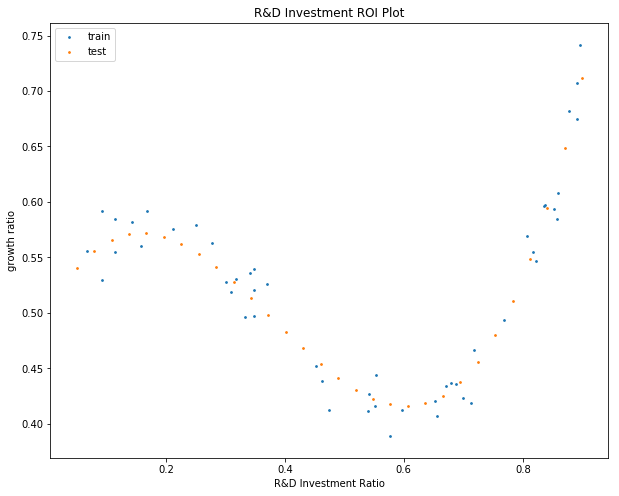

In [36]:
plt.figure(figsize=(10,8))
plt.scatter(train_invests, train_growths, s=3,label='train')
plt.scatter(test_invests, test_growths, s=3,label='test')
plt.title("R&D Investment ROI Plot")
plt.xlabel("R&D Investment Ratio")
plt.ylabel("growth ratio")
plt.legend()
plt.show()

<br><br>

# \[ 1. 정규화의 효과 \]

----

----

> *3층짜리 신경망을 구성해보도록 하겠습니다.* <br>
> *구성한 신경망을 통해 정규화에 따라 어떤식으로 바뀌는지 확인해보도록 하겠습니다.* <br>

<br>
## 1. 정규화 수식이 없는 인공 신경망
---

* 데이터가 부족하거나, 노이즈가 많은 상황에서 인공 신경망은 쉽게 과적합이 될 수 있습니다.<br>

### (1) 모델 구성하기

In [56]:
num_hidden1 = 100 # 1번째 은닉층 unit 수
num_hidden2 = 100 # 2번째 은닉층 unit 수

graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=(None,1),name='X')
    y = tf.placeholder(tf.float32, shape=(None,1),name='y')
    
    # Weight 초기화 함수
    he_init = tf.initializers.he_normal()
    xavier_init = tf.initializers.glorot_normal()
    
    # Graph 부분
    hidden_1 = tf.layers.Dense(num_hidden1, activation=tf.nn.relu,
                               kernel_initializer=he_init, name="hidden_1")(X)
    hidden_2 = tf.layers.Dense(num_hidden2, activation=tf.nn.relu, 
                               kernel_initializer=he_init, name='hidden_2')(hidden_1)
    y_pred = tf.layers.Dense(1,kernel_initializer=xavier_init,
                             name='output')(hidden_2)
    
    # 손실 함수
    loss = tf.losses.mean_squared_error(y, y_pred)
    
    # 성능 지표
    with tf.variable_scope('metric'):
        rmse = tf.sqrt(loss, name='rmse')

    # Summary
    tf.summary.scalar("rmse", rmse)
    tf.summary.scalar("loss", loss)
    
    # training operation
    train_op = (tf.train
                .AdamOptimizer(learning_rate=0.01)
                .minimize(loss))

### (2) 구성한 모델 학습하기 

In [57]:
# 학습
num_step = 28000 # 학습 횟수

start_time = time.time() # 현재 시간 가져오기
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Summary op
    summary_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR+"L2_Loss/train/")
    test_writer = tf.summary.FileWriter(LOG_DIR+"L2_Loss/test/")
    
    for epoch in range(num_step):
        # 학습
        sess.run(train_op,feed_dict={X:train_invests,
                                     y:train_growths})
        if epoch % 50 == 0:
            summary_str = sess.run(summary_op, feed_dict={
                X: train_invests, y:train_growths
            })
            train_writer.add_summary(summary_str, global_step=epoch)
            ## Test
            summary_str,rmse_value = sess.run([summary_op,rmse], 
                          feed_dict={X: test_invests, y:test_growths})
            test_writer.add_summary(summary_str, global_step=epoch)            
            if epoch % 2000 == 0:
                print("{:2d}th epoch RMSE : {:2.3f}".format(epoch, 
                                                        rmse_value))
                
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})

consumed_time = time.time() - start_time # 학습에 총 걸린 시간
print("학습 총 소요 시간 ---- {:.3f}s".format(consumed_time))

 0th epoch RMSE : 1.242
2000th epoch RMSE : 0.013
4000th epoch RMSE : 0.009
6000th epoch RMSE : 0.018
8000th epoch RMSE : 0.011
10000th epoch RMSE : 0.011
12000th epoch RMSE : 0.014
14000th epoch RMSE : 0.012
16000th epoch RMSE : 0.012
18000th epoch RMSE : 0.014
20000th epoch RMSE : 0.016
22000th epoch RMSE : 0.017
24000th epoch RMSE : 0.016
26000th epoch RMSE : 0.016
학습 총 소요 시간 ---- 14.566s


### (3) 결과 확인하기

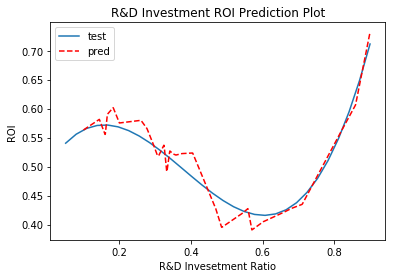

In [58]:
plt.plot(test_invests, test_growths,label='test')
plt.plot(test_xs,pred_ys,'r--',label='pred')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.legend()
plt.show()

<br>
## 2. L2 정규화
---

* 신경망이 데이터를 과대적합하는 문제가 발견되었을 때에는 보통 정규화를 적용합니다.<br>
* 가장 대표적인 정규화에는 매개변수의 제곱항을 추가하는 L2 정규화입니다.<br>
* 선형회귀에 L2 정규화를 취해준 모델을 보통 Ridge 선형회귀라고 부릅니다.


### (1) L2 정규화 수식

L2 정규화란, 손실함수에 매개변수의 제곱항을 추가한 것입니다.<br>

$$
\mbox{손실함수 : } J(w,b) = \frac{1}{m}\sum^{m}_{i=1}L(\hat y^{(i)},y^{(i)}) + \frac{\lambda}{2m}||w||^2\\
$$
추가된 항을 보통 L2 Norm, 혹은 Frobenius 노름이라고 부릅니다.<br>
위의 항을 추가하면, 손실함수의 Gradient 식에 변화가 생깁니다.<br>

$$
dW^{[L]} = \mbox{(기존의 역전파로 온 값)} + \frac{\lambda}{m}W^{[L]}
$$
이를 Gradient Descent 수식에 적용하면 수식이 아래와 같이 변형됩니다.<br>
$$
W_{new}^{[L]} = W^{[L]} - \alpha*dW\\
W_{new}^{[L]} = W^{[L]} - \alpha*(\mbox{(기존의 역전파로 온 값)} + \frac{\lambda}{m}W^{[L]})\\
W_{new}^{[L]} = (1-\frac{\alpha \lambda}{m})W^{[L]} - \alpha*(\mbox{(기존의 역전파로 온 값)}
$$

L2 정규화를 취해주게 되면 언제나 Weight값이 좀 더 줄어드는 효과가 생깁니다.<br>
그렇기 때문에 L2 정규화는 다른 말로 Weight decay라고도 불립니다.

### (2) L2 정규화를 텐서플로우로 구현하기

In [61]:
num_hidden1 = 100 # 1번째 은닉층 unit 수
num_hidden2 = 100 # 2번째 은닉층 unit 수
beta = 0.0005 # l2 parameter

graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=(None,1),name='X')
    y = tf.placeholder(tf.float32, shape=(None,1),name='y')
    
    # Weight 초기화 함수
    he_init = tf.initializers.he_normal()
    xavier_init = tf.initializers.glorot_normal()
    
    # Graph 부분
    hidden_1 = tf.layers.Dense(num_hidden1, activation=tf.nn.relu,
                               kernel_initializer=he_init, name="hidden_1")(X)
    hidden_2 = tf.layers.Dense(num_hidden2, activation=tf.nn.relu, 
                               kernel_initializer=he_init, name='hidden_2')(hidden_1)
    y_pred = tf.layers.Dense(1,kernel_initializer=xavier_init,
                             name='output')(hidden_2)
    
    # 손실 함수
    weights = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    l2_loss = tf.add_n([tf.nn.l2_loss(weight) for weight in weights])
    
    mse = tf.losses.mean_squared_error(y, y_pred)
    loss = mse + beta * l2_loss
    
    # 성능 지표
    with tf.variable_scope('metric'):
        rmse = tf.sqrt(mse, name='rmse')

    # Summary
    tf.summary.scalar("rmse", rmse)
    tf.summary.scalar("loss", loss)
    
    # training operation
    train_op = (tf.train
                .AdamOptimizer(learning_rate=0.01)
                .minimize(loss))


### (3) L2 Loss 추가한 모델 학습시키기 

In [62]:
# 학습
num_step = 28000 # 학습 횟수

start_time = time.time() # 현재 시간 가져오기
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Summary op
    summary_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR+"L1_Loss/train/")
    test_writer = tf.summary.FileWriter(LOG_DIR+"L1_Loss/test/")
    
    for epoch in range(num_step):
        # 학습
        sess.run(train_op,feed_dict={X:train_invests,
                                     y:train_growths})
        if epoch % 50 == 0:
            summary_str = sess.run(summary_op, feed_dict={
                X: train_invests, y:train_growths
            })
            train_writer.add_summary(summary_str, global_step=epoch)
            ## Test
            summary_str,rmse_value = sess.run([summary_op,rmse], 
                          feed_dict={X: test_invests, y:test_growths})
            test_writer.add_summary(summary_str, global_step=epoch)            
            if epoch % 4000 == 0:
                print("{:2d}th epoch RMSE : {:2.3f}".format(epoch, 
                                                        rmse_value))
                
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})

consumed_time = time.time() - start_time # 학습에 총 걸린 시간
print("학습 총 소요 시간 ---- {:.3f}s".format(consumed_time))

 0th epoch RMSE : 0.507
4000th epoch RMSE : 0.012
8000th epoch RMSE : 0.012
12000th epoch RMSE : 0.012
16000th epoch RMSE : 0.012
20000th epoch RMSE : 0.012
24000th epoch RMSE : 0.012
학습 총 소요 시간 ---- 14.015s


### (4) 결과 확인하기 

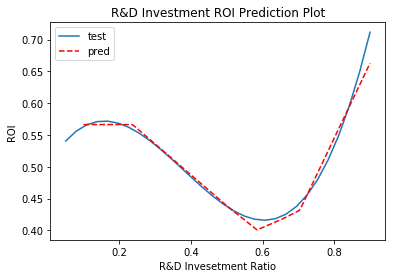

In [63]:
plt.plot(test_invests, test_growths,label='test')
plt.plot(test_xs,pred_ys,'r--',label='pred')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.legend()
plt.show()

<br>
## 3. L1 정규화
---

* 매개변수의 절대값을 추가하는 L1 정규화입니다.<br>
* L1 정규화는 수학적으로는 깔끔한 대수적 해가 존재하지 않을 수 있지만, 좀 더 모델이 Noise에 강건하게 만들어준다고 합니다.<br>
* 선형회귀에 L1 정규화를 취해준 모델을 보통 Lasso 선형회귀라고 부릅니다.


### (1) L1 정규화 수식

L2 정규화란, 손실함수에 매개변수의 절대값을 추가한 것입니다.<br>

$$
\mbox{손실함수 : } J(w,b) = \frac{1}{m}\sum^{m}_{i=1}L(\hat y^{(i)},y^{(i)}) + \frac{\lambda}{2m}||w||\\
$$
추가된 항을 보통 L1 Norm이라고 부릅니다.<br>
위의 항을 추가하면, 손실함수의 Gradient 식에 변화가 생깁니다.<br>

$$
dW^{[L]} = \mbox{(기존의 역전파로 온 값)} + \frac{\lambda}{m}sign(W)
$$

L2 정규화와 달리, Weight의 크기에 비례하지 않고, 단순히 Weight의 부호에 의해 결정됩니다.<br>
이 항의 추가로 인해, 0으로 되도 좋은 weight들을 0으로 만드는 효과를 발생합니다.<br>
그래서 L1 정규화는 주로, 특징 선택을 위한 하나의 수단으로도 이용되어 왔습니다.



### (2) L1 정규화를 텐서플로우로 구현하기

In [67]:
num_hidden1 = 100 # 1번째 은닉층 unit 수
num_hidden2 = 100 # 2번째 은닉층 unit 수
beta = 0.0002 # l1 parameter

graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=(None,1),name='X')
    y = tf.placeholder(tf.float32, shape=(None,1),name='y')
    
    # Weight 초기화 함수
    he_init = tf.initializers.he_normal()
    xavier_init = tf.initializers.glorot_normal()
    
    # Graph 부분
    hidden_1 = tf.layers.Dense(num_hidden1, activation=tf.nn.relu,
                               kernel_initializer=he_init, name="hidden_1")(X)
    hidden_2 = tf.layers.Dense(num_hidden2, activation=tf.nn.relu, 
                               kernel_initializer=he_init, name='hidden_2')(hidden_1)
    y_pred = tf.layers.Dense(1,kernel_initializer=xavier_init,
                             name='output')(hidden_2)
    
    # 손실 함수
    weights = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    l1_loss = tf.add_n([tf.reduce_sum(tf.abs(weight))
                        for weight in weights])
    
    mse = tf.losses.mean_squared_error(y, y_pred)
    loss = mse + beta * l1_loss
    
    # 성능 지표
    with tf.variable_scope('metric'):
        rmse = tf.sqrt(mse, name='rmse')

    # Summary
    tf.summary.scalar("rmse", rmse)
    tf.summary.scalar("loss", loss)
    
    # training operation
    train_op = (tf.train
                .AdamOptimizer(learning_rate=0.01)
                .minimize(loss))


### (3) L1 Loss 추가한 모델 학습시키기 

In [68]:
# 학습
num_step = 28000 # 학습 횟수

start_time = time.time() # 현재 시간 가져오기
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Summary op
    summary_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR+"batch_GD/train/")
    test_writer = tf.summary.FileWriter(LOG_DIR+"batch_GD/test/")
    
    for epoch in range(num_step):
        # 학습
        sess.run(train_op,feed_dict={X:train_invests,
                                     y:train_growths})
        if epoch % 50 == 0:
            summary_str = sess.run(summary_op, feed_dict={
                X: train_invests, y:train_growths
            })
            train_writer.add_summary(summary_str, global_step=epoch)
            ## Test
            summary_str,rmse_value = sess.run([summary_op,rmse], 
                          feed_dict={X: test_invests, y:test_growths})
            test_writer.add_summary(summary_str, global_step=epoch)            
            if epoch % 4000 == 0:
                print("{:2d}th epoch RMSE : {:2.3f}".format(epoch, 
                                                        rmse_value))
                
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})

consumed_time = time.time() - start_time # 학습에 총 걸린 시간
print("학습 총 소요 시간 ---- {:.3f}s".format(consumed_time))

 0th epoch RMSE : 1.736
4000th epoch RMSE : 0.011
8000th epoch RMSE : 0.010
12000th epoch RMSE : 0.010
16000th epoch RMSE : 0.010
20000th epoch RMSE : 0.010
24000th epoch RMSE : 0.010
학습 총 소요 시간 ---- 15.893s


### (4) 결과 확인하기 

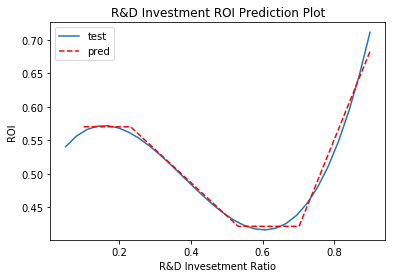

In [69]:
plt.plot(test_invests, test_growths,label='test')
plt.plot(test_xs,pred_ys,'r--',label='pred')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.legend()
plt.show()

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/05

---